# Investigate Agenda Setting

In [1]:
import pandas as pd 
import json
import numpy as np 
import matplotlib.pyplot as plt 

In [ ]:
df_final = pd.read_parquet("../data/parllaw/final.parquet")
final_topic_col = "migration_prob"
final_threshold = 0.25
embedding_model = 'google/embeddinggemma-300m'
party_column = "block" # "party"

In [3]:
df_migration = pd.read_parquet("../data/embeddings/speech_embeddings.parquet")

In [4]:
df_final.index

Index([     1,      3,      4,      5,      6,      7,      8,      9,     10,
           11,
       ...
       292033, 292034, 292035, 292036, 292037, 292043, 292046, 292048, 292051,
       292054],
      dtype='int64', length=236812)

In [5]:
# only the speeches that are classified as migration 
df_migration_speeches = df_final[df_final[final_topic_col] >= final_threshold]

# full debates where at least one speech is migration related
df_all_speeches_with_one_migration_in_agenda = df_final[df_final["agenda"].isin(df_migration_speeches["agenda"])]

In [205]:
def print_agendas(agenda_items, first_k=3):
    """
    For each agenda item of the first k in agenda_items:
    Print the debates of the agenda items, by printing
    Agenda title etc.
    [{x if classfied as migration}] {speechnumber}: {speaker} {party block} {migration score} \n speech
    """
    for agenda in agenda_items[:first_k]: 
        df_agenda = df_final[df_final["agenda"] == agenda]
        print(agenda)
        
        migration_contributions = df_agenda[df_agenda[final_topic_col] > final_threshold]

        print("Parties talking about migration:", ', '.join (f'{b} ({n})' for b, n in migration_contributions[party_column].value_counts().items()))
        for _, row in df_agenda.iterrows():
            migration_score = row[final_topic_col]
            marker_is_migration = "[x]" if migration_score > final_threshold else "[ ]"

            translatedText = row["translatedText"].replace("\n", "\n\t")
            print(f'{marker_is_migration} {row["speechnumber"]}: {row["speaker"]} ({row["party"]} - {row["block"]}) [{int(migration_score*100)}% migration]\n\t{translatedText}')

        print("="*50, "end of agenda item", "="*50)

In [ ]:
def entropy(values): 
    # Compute the shannon entropy of the value series
    total = len(values)

    probs = np.array([n/total for _, n in values.value_counts().items()])
    log_probs = np.log2(probs)
    return - (probs * log_probs).sum()

def effective_number_of_parties(values): 
    # Compute the effective number of parties (https://en.wikipedia.org/wiki/Effective_number_of_parties)
    probs = np.array(values.value_counts(normalize=True))
    return 1 / (probs * probs).sum()

migration_speeches_grouped_by_agenda = df_migration_speeches.groupby("agenda").agg(
    party_entropy_migration = pd.NamedAgg(party_column, entropy), 
    n_parties_migration = pd.NamedAgg(party_column, lambda x: len(set(x))),
    parties_migration = pd.NamedAgg(party_column, set), 
    n_speeches_migration = pd.NamedAgg("translatedText", len),
    effective_n_parties_migration = pd.NamedAgg(party_column, effective_number_of_parties),
)
all_speeches_grouped_by_agenda = df_all_speeches_with_one_migration_in_agenda.groupby("agenda").agg(
    party_entropy = pd.NamedAgg(party_column, entropy), 
    n_parties = pd.NamedAgg(party_column, lambda x: len(set(x))),
    parties = pd.NamedAgg(party_column, set), 
    n_speeches = pd.NamedAgg("translatedText", len),
    avg_migration_score = pd.NamedAgg(final_topic_col, "mean"),
    effective_n_parties = pd.NamedAgg(party_column, effective_number_of_parties),
    date = pd.NamedAgg("date", "first"), # assume the date is the same for all agenda items, 
    year = pd.NamedAgg("year", "first") 
)

# dataframe created has per agenda item:
# 'party_entropy[_migration]': entropy of parties talking about this agenda item [about migration]
# 'n_parties[_migration]': number of parties ... 
# 'effective_n_parties[_migration]'
# 'parties[_migration]': list of parties ... 
# 'n_speeches[_migration]': number of speeches in this agenda item [about migration]
# 'avg_migration_score': average migration score of the speeches
# proportion_migration_speeches

migration_agendas = all_speeches_grouped_by_agenda.join(migration_speeches_grouped_by_agenda)
migration_agendas["proportion_migration_speeches"] = migration_agendas["n_speeches_migration"] / migration_agendas["n_speeches"]

In [50]:
len(migration_agendas[migration_agendas["n_speeches_migration"] == 0])

0

## Agendas with many migration speeches: 

In [8]:
min_avg_migration_score = migration_agendas["avg_migration_score"].mean() + migration_agendas["avg_migration_score"].std()
# use final threshold instead? 

agendas_many_migration_speeches = migration_agendas[migration_agendas["avg_migration_score"] > min_avg_migration_score]
print(len(agendas_many_migration_speeches),"agenda items with >", min_avg_migration_score, "avg. migration score")


for i, item in enumerate(agendas_many_migration_speeches.index.unique()):
    print(i, item)

177 agenda items with > 0.26751794411413404 avg. migration score
0 1. Opening of the sitting2018-10-03
1 10. EU policies and actions to protect children in the context of migration (debate)2016-10-26
2 10. Legal migration policy and law (debate)2021-11-23
3 10. Major interpellations (debate)2024-02-29
4 10. Provisional measures in the area of international protection for the benefit of Italy and Greece (debate)2015-09-08
5 10. Refugee emergency, external borders control and future of Schengen - Respect for the international principle of non-refoulement - Financing refugee facility for Turkey - Increased racist hatred and violence against refugees and migrants across Europe (debate)2016-02-02
6 10. Signing of acts adopted in accordance with the ordinary legislative procedure (Rule 79)2023-05-31
7 10. Verification of credentials2018-07-03
8 10.1. Refugees in Europe: CARE (C9-0057/2022)2022-03-24
9 10.4. EU Protection of children and young people fleeing the war against Ukraine (B9-0207/2

In [9]:
print_agendas(agendas_many_migration_speeches.index, 1)

17. Screening of third country nationals at the external borders - European Criminal Records Information System - Third Country Nationals - Common procedure for international protection in the Union - Establishing a return border procedure, and amending Regulation (EU) 2021/1148 - Asylum and migration management - Addressing situations of crisis and force majeure - Establishment of 'Eurodac' for the comparison of fingerprints for the effective application of Regulation (EU) No 604/2013, for identifying an illegally staying third-country national or stateless person and on requests for the comparison with Eurodac data by Member States' law enforcement authorities and Europol for law enforcement purposes (recast) - Union Resettlement Framework - Standards for the qualification of third-country nationals or stateless persons as beneficiaries of international protection - Standards for the reception of applicants for international protection (recast) (joint debate - Migration and Asylum pa

=> the agenda is very much related to migration! but the speeches marked as non-migration are indeed also not clearly about migration (e.g. "Madam President, whether it was an official reprimand or not, Mr Vandendriessche has been told that he cannot use Nazi terminology in this chamber and that he was not allowed to do so. So I expect the Presidency of this House to take the necessary steps.": 0% migration); => we should not include these for our embedding analyses because they introduce noise.

## Do parties do agenda-setting?

only considering agenda items with > 5.459389843744717 speeches: 978 of 1054


<Axes: title={'center': 'How many parties (effectively) talk about migration per agenda item? [Frequency]'}, ylabel='Frequency'>

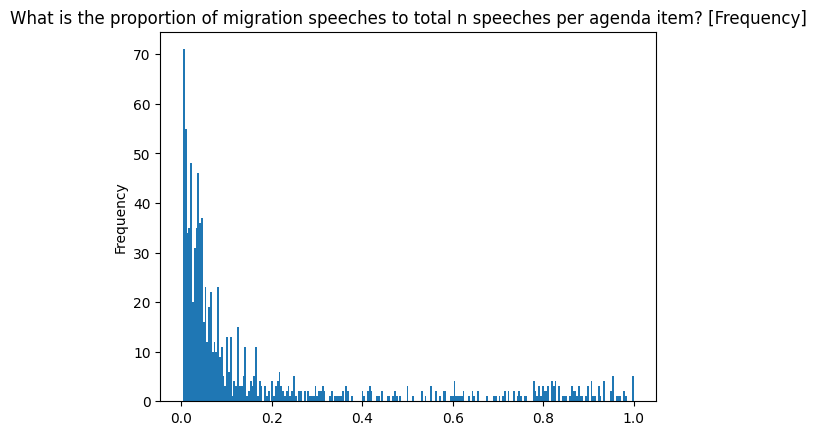

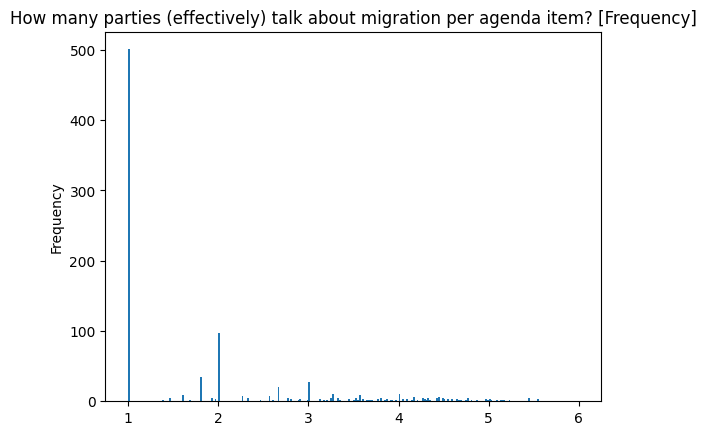

In [10]:
# ignore agenda items with only a few speeches
min_speeches_per_agenda = migration_agendas["n_speeches"].mean() - migration_agendas["n_speeches"].std()

migration_agendas_with_debates = migration_agendas[migration_agendas["n_speeches"] > min_speeches_per_agenda].sort_values("n_speeches")
print("only considering agenda items with >", min_speeches_per_agenda, "speeches:", len(migration_agendas_with_debates), "of", len(migration_agendas))

plt.figure()
migration_agendas_with_debates["proportion_migration_speeches"].plot.hist(bins=250, title="What is the proportion of migration speeches to total n speeches per agenda item? [Frequency]")
plt.figure()
migration_agendas_with_debates["effective_n_parties_migration"].plot.hist(bins=250, title="How many parties (effectively) talk about migration per agenda item? [Frequency]")

Other analyses: 
- agenda setting is not n_speeches_migration == 1 (what if two people from the same party keep setting the agenda) 
=> instead: look at those agenda items, where the party entropy is low => when it is 0: the party is the only party that talks about migration
- but: what if only conservative & right parties talk about migration? => TODO: capure this
- then: is there a yearly trend? => did agenda setting increase over time? did conservative parties start to also join agenda setting?

In [11]:
# Source - https://stackoverflow.com/a
# Posted by Padraic Cunningham, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-25, License - CC BY-SA 3.0

from collections import Counter
from itertools import combinations

def count_pairs(partent_list):
    d  = Counter()
    for sub in partent_list:
        if len(partent_list) > 1: 
            sub = list(sub)
            sub.sort()
            for comb in combinations(sub, 2):
                d[comb] += 1
    return d 

In [12]:
def investigate_agenda_setting(year=None, effective_n_parties_threshold=2): 
    # effective n parties migration <= 1? 
    # TODO prop effective n parties miration / n parties general should be low? 
    agendas_with_low_n_parties_migration = migration_agendas_with_debates[migration_agendas_with_debates["effective_n_parties_migration"] <= effective_n_parties_threshold]
    
    # only in that year
    if year is not None:
        agendas_with_low_n_parties_migration = agendas_with_low_n_parties_migration[agendas_with_low_n_parties_migration["year"] == year]

    frequency_of_parties = Counter()
    n_agenda_items_with_low = len(agendas_with_low_n_parties_migration)
    agenda_items_per_party = dict() 

    for party in df_final[party_column].unique(): 
        agenda_items_with_that_party = agendas_with_low_n_parties_migration[agendas_with_low_n_parties_migration["parties_migration"].apply(lambda parties: party in parties)]
        frequency_of_parties[party] = len(agenda_items_with_that_party)/n_agenda_items_with_low
        agenda_items_per_party[party] = agenda_items_with_that_party

    team_counts = count_pairs(agendas_with_low_n_parties_migration["parties_migration"])

    return n_agenda_items_with_low, frequency_of_parties, team_counts, agenda_items_per_party

In [13]:
n_items, f_parties, team_counts, agenda_items = investigate_agenda_setting()
print_agendas(agenda_items["green"].index, 5)

17. EU-Egypt strategic and comprehensive partnership and agreements with key third countries (debate)2024-04-23
Parties talking about migration: green (1)
[ ] 3: Francisco José Millán Mon (PPE - christian_conservative) [0% migration]
	Mr President, I thank Vice-President Schinas for his very comprehensive presentation. The European Union is going through a very serious situation. In the last two years, Russia's unjustified war against Ukraine has concentrated our efforts, but it cannot make us forget the Southern Neighbourhood. The serious risk of escalation in the Middle East, the difficulties faced by the countries of the Southern Neighbourhood, or the situation in the Sahel are profound challenges that the European Union cannot ignore. We must act. The agreements with Egypt, or the recent ones with Tunisia and Mauritania, are therefore heading in the right direction. Egypt is a very important neighbour, with significant geostrategic weight. The joint declaration of 17 March, promote

2024 [(('liberal', 'social_democratic'), 2)]
2023 [(('(extreme)_right', 'christian_conservative'), 6)]
2022 [(('(extreme)_right', 'green'), 2)]
2021 [(('(extreme)_right', 'green'), 3)]
2020 [(('(extreme)_right', 'christian_conservative'), 1)]
2019 [(('(extreme)_right', 'social_democratic'), 3)]
2018 [(('(extreme)_right', 'social_democratic'), 5)]
2017 [(('(extreme)_right', 'liberal'), 3)]
2016 [(('(extreme)_right', 'social_democratic'), 14)]
2015 [(('(extreme)_right', 'christian_conservative'), 12)]
2014 [(('(extreme)_right', 'social_democratic'), 1)]


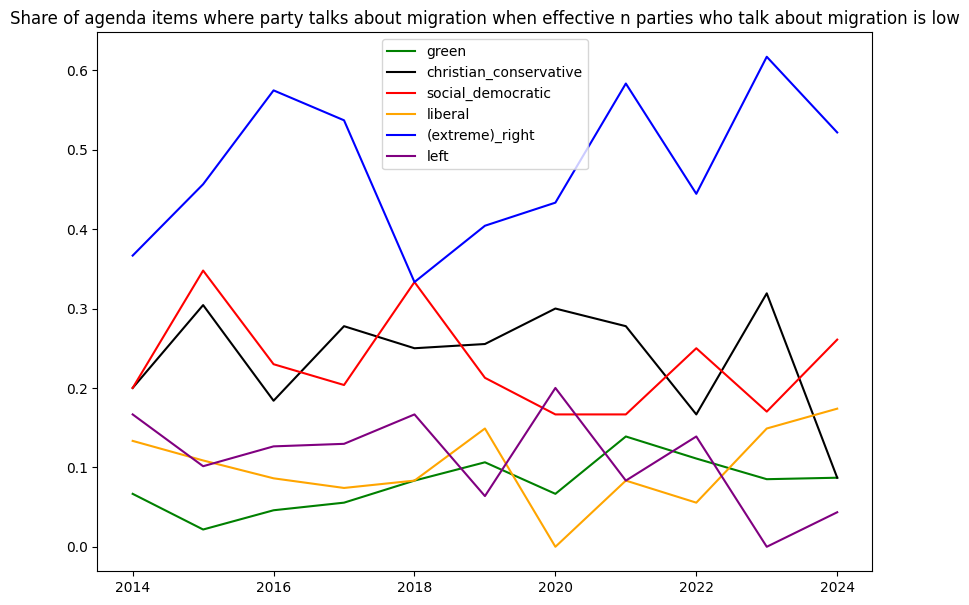

In [14]:
plt.figure(figsize=(10, 7))
plt.title("Share of agenda items where party talks about migration when effective n parties who talk about migration is low")
colormap = json.load(open(f"../plotting_parameters/color_maps/color_map_{party_column}.json"))

years = []
n_per_party = {p: [] for p in df_final[party_column].unique()}

for year in df_final["year"].unique():
    years.append(year)

    n_agendas, counts_per_party, counts_per_team, _ = investigate_agenda_setting(year, 2)
    for party, proportion in counts_per_party.items():
        n_per_party[party].append(proportion)

    print(year, counts_per_team.most_common(1))
for party in n_per_party.keys(): 
    plt.plot(years, n_per_party[party], label=party, c=colormap[party])
plt.legend()

In [15]:
agenda_items_with_agenda_setting = (migration_agendas_with_debates[migration_agendas_with_debates["effective_n_parties_migration"] == 1]).index
df_agenda_setting_candidates = df_final[df_final["agenda"].isin(agenda_items_with_agenda_setting)]
print(len(agenda_items_with_agenda_setting),"agenda items with agenda setting")

501 agenda items with agenda setting


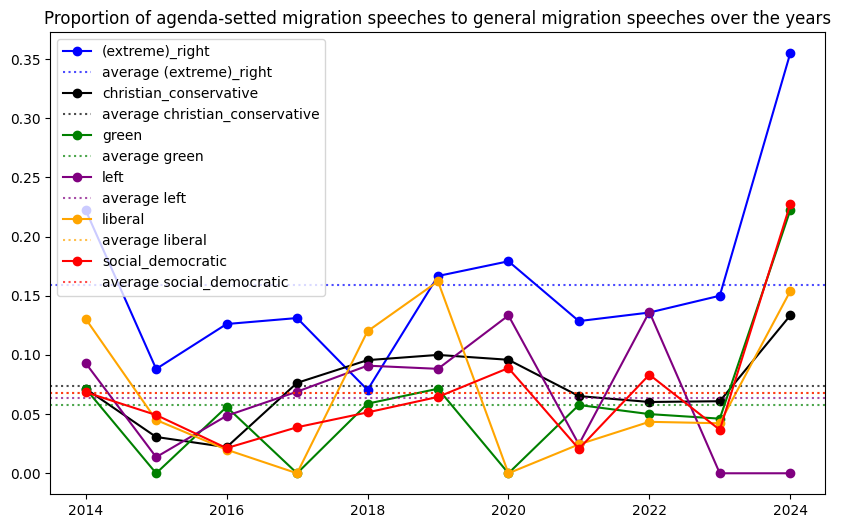

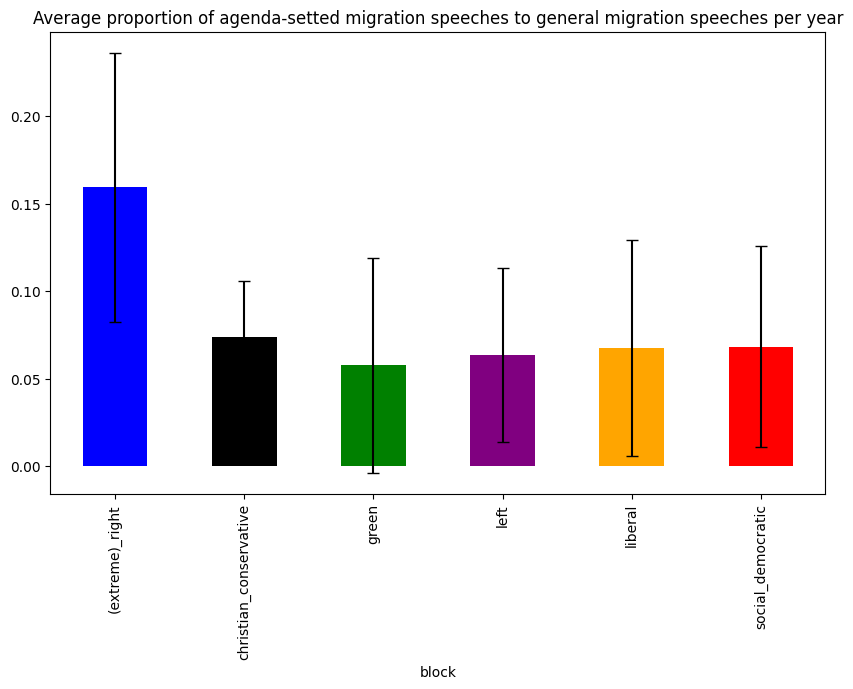

Explanation of plot: 
      This only considers agenda items with > 6 contributions (=> there needs to be some debate). 
      In these: for each party, what share of their migration speeches were agenda-setting speeches 
      (i.e. that party was the only one talking about migration)


In [126]:
def count_migration_speeches(df: pd.DataFrame): 
    return df[df[final_topic_col] > final_threshold].groupby(["block", "year"]).size().unstack(fill_value=0)

# per party: what is the number of speeches that the party is talking about migration, but is the only one (in the agenda items where there is a debate)
n_migration_speeches_per_party_agenda_setted = count_migration_speeches(df_agenda_setting_candidates)

# compare this to: 
# per party: what is the number of speeches that the party is talking about migration in total (in the agenda items where there is a debate)
n_migration_speeches_per_party_total = count_migration_speeches(df_final[df_final["agenda"].isin(migration_agendas_with_debates.index)])


proportion_agenda_set_speeches = n_migration_speeches_per_party_agenda_setted/n_migration_speeches_per_party_total

# we have data in wide format (block, year_1, ..., year_n)
# but we want to have (block, year, value)
proportion_per_block = proportion_agenda_set_speeches.reset_index().melt(id_vars="block", var_name="year", value_name="value").groupby("block")
avg_proportion_per_block = proportion_per_block["value"].mean()

plt.figure(figsize=(10, 6))
for party, values in proportion_per_block: 
    color = colormap[party]

    plt.plot(values["year"], values["value"], label=party, marker="o", c=color)
    plt.axhline(avg_proportion_per_block[party], c=color, alpha=0.7, linestyle=":", label="average "+party)

plt.title("Proportion of agenda-setted migration speeches to general migration speeches over the years")
plt.legend()
plt.show()

avg_proportion_per_block.plot(
    kind="bar", 
    figsize=(10, 6),
    color=avg_proportion_per_block.index.map(colormap), 
    yerr=proportion_per_block["value"].std(), 
    capsize=4,
    title="Average proportion of agenda-setted migration speeches to general migration speeches per year"
)
plt.show()
print("""Explanation of plot: 
      This only considers agenda items with > 6 contributions (=> there needs to be some debate). 
      In these: for each party, what share of their migration speeches were agenda-setting speeches 
      (i.e. that party was the only one talking about migration)"""
)


## When do partys do agenda-setting?

First, clean the agenda titles (remove comments, and date)

In [183]:
# for each party, find one example of agenda setting: 
import re 

agenda_titles_with_agenda_setting = []
for party in df_final[party_column].unique(): 
    def clean_agenda_title(title): 
        # remove date from agenda item 
        title = title[:-10]
        # remove bracketed comments 
        title = re.sub(r'\(.*\)', '', title)
        # only keep letters and : or -
        title = re.sub(r'[^A-Za-z:\- ]+', '', title)
        title = title.strip()
        return title 

    agenda_items_that_party_did_agenda_setting = df_agenda_setting_candidates[(df_agenda_setting_candidates[final_topic_col] > final_threshold) & (df_agenda_setting_candidates[party_column] == party)]["agenda"].unique()

    for title in agenda_items_that_party_did_agenda_setting: 
        agenda_titles_with_agenda_setting.append({party_column: party, "cleaned": clean_agenda_title(title), "raw": title})

# now have dataframe with party, cleaned (cleaned agenda title), raw (full agenda title)
# => all titles of agenda items where that party agenda-set migration
agenda_titles_with_agenda_setting = pd.DataFrame(agenda_titles_with_agenda_setting)
agenda_titles_with_agenda_setting.drop_duplicates(subset=[party_column, "cleaned"], inplace=True)

Load embedding model to embedd agenda item titles

In [184]:
from transformers import AutoModel
from sentence_transformers import SentenceTransformer
import torch 

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu" 

model = SentenceTransformer(embedding_model, trust_remote_code=True).to(device)
def embedd_texts(model, texts, task="text-matching", batch_size=32):
    return model.encode(texts, task=task, batch_size=batch_size)

In [185]:
titles_embeddings = embedd_texts(model, agenda_titles_with_agenda_setting["cleaned"].tolist(), task="classification")
agenda_titles_with_agenda_setting["embedding"] = titles_embeddings.tolist()

Fit linear regression model to see if there is a meaningful pattern within the agenda item titles 
=> Question: do parties talk about migration in party-specific contexts?

In [187]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

regression_model = LogisticRegression()

X = np.stack(agenda_titles_with_agenda_setting["embedding"])
y = np.array(agenda_titles_with_agenda_setting[party_column])
regression_model.fit(X, y) 

# make sure the model is not learning the embeddings by heart => evaluation not on raw X, but on StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(regression_model, X, y, cv=cv, scoring="accuracy")

print("Cross validation accuracy:", scores.mean())
print("Cross validation std:", scores.std())

Cross validation accuracy: 0.4245771670190274
Cross validation std: 0.035996761872007836


=> there is a pattern in the data (party is predictable from agenda title embedding)
=> what agenda item titles are most characteristic for each party? in other words, for each party, based on the agenda item title, where do we know with most certainty that the party will agenda-set, rather than a different party?

In [201]:
scores = regression_model.predict_proba(X)
print_top_k = 15
agenda_title_column = "cleaned" # "raw"
most_decisive_titles = {}
print("Most decicive agenda titles:")
for i, party in enumerate(regression_model.classes_):
    top_idx = np.argsort(-scores[:, i])[:print_top_k]

    # NOTE: this includes also false-positives, the acutal agenda setting party might be another,
    # this is just where the model is surest that it is the current party
    print(f"\n{party}")
    for k in top_idx: 
        print(agenda_titles_with_agenda_setting.iloc[k][agenda_title_column], "|", party == agenda_titles_with_agenda_setting.iloc[k][party_column])
    # print("\n".join(agenda_titles_with_agenda_setting.iloc[top_idx][agenda_title_column]))
    print("="*100)
    # keep full agenda to investigate further
    most_decisive_this_party = agenda_titles_with_agenda_setting.iloc[top_idx]
    most_decisive_this_party = most_decisive_this_party[most_decisive_this_party[party_column] == party].reset_index()
    most_decisive_titles[party] = most_decisive_this_party["raw"]


Most decicive agenda titles:

(extreme)_right
EU-Timor-Leste agreement on the short-stay visa waiver | True
EU-Samoa agreement on the short-stay visa waiver | True
EU-Vanuatu agreement on the short-stay visa waiver | True
EU-Dominica agreement on the short-stay visa waiver | True
EU-United Arab Emirates agreement on the short-stay visa waiver | True
EU Agency for Law Enforcement Training | True
EU-Tonga Agreement on the short-stay visa waiver | True
Women domestic workers and carers in the EU | True
EU-Palau Agreement on the short-stay visa waiver | True
EU-Solomon Islands Agreement on the short-stay visa waiver | True
EU-Saint Vincent and the Grenadines agreement on the short-stay visa waiver | True
EU-Trinidad and Tobago agreement on the short-stay visa waiver | True
EU-Marshall Islands Agreement on the short-stay visa waiver | False
EU-Saint Lucia agreement on the short-stay visa waiver | True
Discharge : European Fisheries Control Agency | True

christian_conservative
progress repo

In [206]:
for party, most_decisive_this_party in most_decisive_titles.items(): 
    print(party)
    # print(most_decisive_this_party)
    print_agendas(most_decisive_this_party, 3)   
    print("\n"*5)

(extreme)_right
5.7. EU-Timor-Leste agreement on the short-stay visa waiver (A8-0327/2015 - Mariya Gabriel)2015-12-15
Parties talking about migration: (extreme)_right (2)
[ ] 1: Marina Albiol Guzmán (NGL/The Left - left) [0% migration]
	This agreement allows Timorese and European citizens to travel through both territories without the need for a visa. Despite disagreeing with the way in which the negotiations have been carried out - with obscurantism and without the participation of parliaments -, I have voted in favor of its ratification since we are fine with anything that represents a lightening of bureaucratic burden and the end of restrictions on freedom of movement.
[ ] 2: Louis Aliot (ENF/ID - (extreme)_right) [14% migration]
	I voted against the agreement with East Timor on the visa waiver for short stays. If in this report the liberalization of visas for short-term stays is presented as an opportunity to boost tourism, simplify travel conditions for entrepreneurs or even encou

In [29]:
# # group by party + how many uq agendas per party (normalized by how many )
# # df_migration = df_final[df_final[final_topic_col] > final_threshold]

# n_agendas_per_block_migration = df_migration.groupby("block").agg(
#     n_speeches_migration = pd.NamedAgg("translatedText", len), 
#     n_agendas_migration=pd.NamedAgg("agenda", lambda agendas: len(set(agendas)))
# )
# n_agendas_per_block_all = df_final.groupby("block").agg(n_agendas_all=pd.NamedAgg("agenda", lambda agendas: len(set(agendas))))

# n_agendas_per_block = n_agendas_per_block_migration.join(n_agendas_per_block_all)
# n_agendas_per_block["proportion_migration"] = n_agendas_per_block["n_agendas_migration"] / n_agendas_per_block["n_agendas_all"] 
# n_agendas_per_block["proportion_speech_num_migration_agenda"] = n_agendas_per_block["n_speeches_migration"] / n_agendas_per_block["n_agendas_migration"] 
# n_agendas_per_block.sort_values("proportion_speech_num_migration_agenda", ascending=False)